# Udacity Data Science Nanodegree - Boston Airbnb Open Data


This Jupyter Notebook is the result of the first Data Science project of the Udacity Data Science Nanodegree. It is based on Airbnb data available on Kaggle: https://www.kaggle.com/datasets/airbnb/boston?select=listings.csv

## Description of the Dataset
The dataset describes the activity of homestays in Boston, MA. It contains a dataset of listings, including their full descriptions and average rating scores; a dataset of ratings, including each rater's unique ID and detailed comments; and a dataset called Calendar, which contains the listing ID and price, as well as availability for a given day. 
This dataset can be used to explore many different questions. This notebook focuses on the following questions:

## Research Questions
1. How long do people rent homes in Boston? 
2. What makes a successfull desription of an advertised home?
3. What are the features, that influence the price the most?  


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap 
from yellowbrick.regressor import PredictionError
%matplotlib inline 

### First Research Question
In order to find out how long people stayed in the homes in Boston we will use the calendar data set. 

In [2]:
calendar_data = pd.read_csv('calendar.csv', sep = ',')
calendar_data.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


Let us check if we have any NaN values except in the price coulmn.

In [3]:
calendar_data.isna().any()

listing_id    False
date          False
available     False
price          True
dtype: bool

To answer the question of how long the guest stays, I have come across the problem that the listing ID and date combination is duplicated. Therefore, we remove the duplicates:

In [4]:
print('Are there any duplicated rows in the calendar dataset: ' + \
      str(calendar_data.duplicated(subset = ['listing_id','date']).any()))
calendar_data = calendar_data.drop_duplicates(subset = ['listing_id', 'date'])

Are there any duplicated rows in the calendar dataset: True


In order to have a better understanding, let us show how long the total data was recorded.

In [5]:
calendar_data.date = pd.to_datetime(calendar_data.date)
time_frame = max(calendar_data.date) - min(calendar_data.date)
print('The data ranges over ' + str(time_frame.days+1) +' days from ' + str(min(calendar_data.date)) + ' to ' + \
      str(max(calendar_data.date)) + '.')

The data ranges over 365 days from 2016-09-06 00:00:00 to 2017-09-05 00:00:00.


Now we would like to see the total amount of time a home is rented out. We can get this information from the listings data set.

In [6]:
listing_data = pd.read_csv('listings.csv', sep = ',')
listing_data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [7]:
total_rented_times = listing_data['availability_365'].to_frame()
total_rented_times.describe()

,availability_365
count,3585.000000
mean,179.346444
std,142.136180
min,0.000000
25%,19.000000
50%,179.000000
75%,325.000000
max,365.000000


In [8]:
print('Number of homes that were not rented out at all: ' + str((total_rented_times == 0).sum()[0]))
print('Number of homes that were rented out all year: ' + str((total_rented_times == 365).sum()[0]))

Number of homes that were not rented out at all: 679
Number of homes that were rented out all year: 103


In total we have 3584 homes in our dataset. We see that some of the homes were rented for a whole year and almost one fifth were not rented at all. The average time a home was rented in that year was about half a year. From the standard deviation, however, we can see that the total time a home was rented varied greatly.

array([[<AxesSubplot:title={'center':'availability_365'}>]], dtype=object)

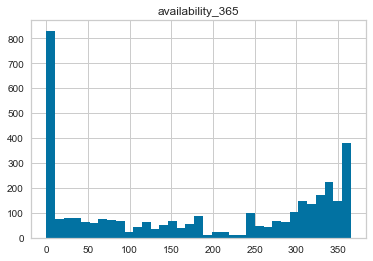

In [9]:
total_rented_times.hist(bins = np.linspace(0, 365, num=365//10))

From the histogram we can see that there are a large number of homes that were only rented for a short time or not at all. On the other hand, there are quite a number of flats that were rented out for almost the whole year.

Let us now look at the periods during which people stayed in the flats. To do this, we need to extract the periods during which the flats were rented out.

In [10]:
#We change the available column to boolean values
calendar_data = calendar_data.replace({'available' : {'f': False,'t':True}})
#we sort our data by the id and the date
calendar_data = calendar_data.sort_values(by = ['listing_id', 'date'])
#Then we add a column whith a cummulative sum when the home is rented out which is set back to zero 
#when the home was free again
calendar_data['time_period'] = calendar_data.groupby(['listing_id', calendar_data.available.cumsum()]).cumcount()
#Finally we just extract the value at the end of each period and we add one for 
#first occurence of the listing id since cumcount starts with zero
rented_duration = calendar_data[['listing_id','time_period']][(calendar_data.available.shift(-1) & 
                                                               ~(calendar_data.available))]                                  
rented_duration.loc[~(rented_duration.duplicated(subset='listing_id', keep='first')),'time_period'] += 1
rented_duration.time_period.describe()

count    11774.000000
mean        20.324698
std         52.656794
min          1.000000
25%          3.000000
50%          5.000000
75%         11.000000
max        365.000000
Name: time_period, dtype: float64

The descriptive statistics show that there were 11774 stays in Boston that year and that the average length of stay was about 20 days. However, using the percentiles, we can see that the majority only stayed for a short time, as the 75% percentile is 11 days. This should be underlined by a histogram.

Text(0, 0.5, 'Counts')

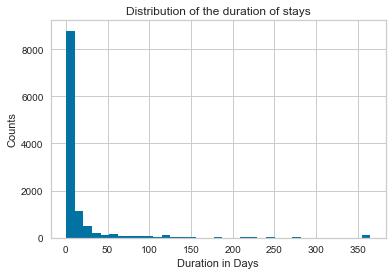

In [11]:
rented_duration.time_period.hist(bins = np.linspace(0, 365, num=365//10))
plt.title('Distribution of the duration of stays')
plt.xlabel('Duration in Days')
plt.ylabel('Counts')


[]

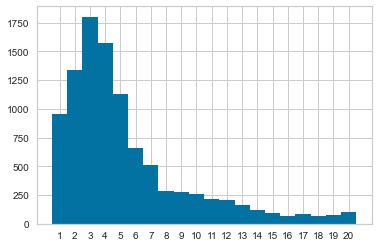

In [12]:
rented_duration.time_period.hist(bins = range(1,22))
plt.xticks(np.arange(1.5, 21.5, 1), range(1, 21))
plt.plot()

The distributaion shows us, that the majority of stays were for short time periods. If we only look at the distribution of periods of less than 20 days, we see that most stays did not last longer than a week. We can also see that there is a peak at three days, which could be the duration of a weekend or business trip.

## Second Research Question
To find out what makes a successful description of an advertised home, we would like to find out the words that are most often used in descriptions of homes that are frequently rented. To answer this question, we will use the data of the listing and the calendar data.

Let us first check if all of homes in the calendar are also represented in the listing.

In [13]:
if set(calendar_data.listing_id.unique()) == set(listing_data.id.unique()):
    print('We have the same homes in both files!')
else:
    print('There are not the same homes in both files.')

We have the same homes in both files!


Let us see if all of the homes have a description.

In [14]:
print('In total there are ' + str(listing_data.description.isna().sum()) +' missing descriptions.')

In total there are 0 missing descriptions.


Now we combine the information from both datasets:

In [15]:
descriptions = listing_data.description.to_frame()
description_time = pd.concat([descriptions, total_rented_times], axis = 1)
description_time.set_index(listing_data.id, inplace = True)

In order to create a wordcloud we need each word seperated. Therfore we split the descriptions into words and associate them with the corresponding value for the time the home has been rented out.

In [16]:
words_and_values = []
for index, row in description_time.iterrows():
    for word in row['description'].split():
        words_and_values.append([word, row['availability_365']])
   

We will filter the words: stop words and numbers will be deleted, as well as punctuation marks. We also delete the word "Boston", as it is probably used in most descriptions and does not give us any additional information. We will also remove all words that are smaller than three letters.  

In [17]:
nltk.download('stopwords',quiet=True)
stopping_words = nltk.corpus.stopwords.words('english')
stopping_words.extend(['the', 'one', 'two', 'three', 'four', 'also', 'boston'])
words_and_values = [word for word in words_and_values if word[0].isalpha() and 
                    word[0].lower() not in stopping_words and len(word[0])>=3]
words_and_values = pd.DataFrame(words_and_values, columns = ['words', 'values'])

Now we weight the words depending on how often the home, in which the word was used, was rented out. Also let us just look at the top 100 words.

In [18]:
words_and_values = words_and_values.groupby('words').sum().sort_values(by ='values', ascending = False).head(100)
words_and_values.head()

,values
words,
room,420452
apartment,417414
walk,351674
living,301124
bedroom,297893


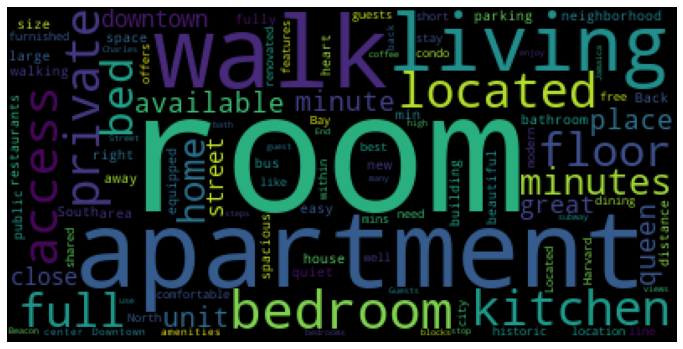

In [19]:
words = [(word, value) for word, value in zip(words_and_values.index, words_and_values['values'])]
wordcloud = WordCloud().generate_from_frequencies(dict(words))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

A word cloud is a nice tool to display these words, but it is difficult to analyse. We can see that the word room is the most common, which suggests that it is easy to rent out individual rooms. However, the next most common word is apartament, which is probably the type of home that is also commonly rented out. We see many adjectives such as large, quiet, spacious, etc. Obviously, the homes that use these words in their description are more successful.

<AxesSubplot:title={'center':'Histogram of Words'}, xlabel='words'>

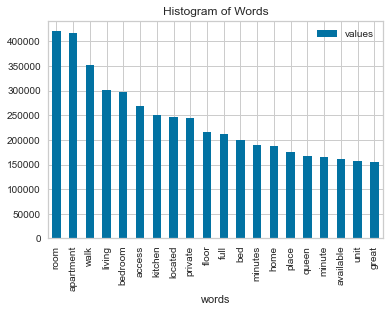

In [20]:
words_and_values.head(20).plot.bar(title = 'Histogram of Words')

In the histogram we see that "walk" is the third most important word. Therefore, it might be useful to indicate in your description what there is to visit within walking distance from your flat. The word kitchen shows us that flats that have a kitchen are rented more. 

### Third Research Question
Now we want to find out which features have the greatest influence on pricing. For this we will use a technique from the field of explainable AI, namely shap values of the features of a random forest. But as always, we start by cleaning up the data in the listing dataset. There are some columns we can leave out as they have no impact on the price, such as the ID or the thumbnail_url.

In [21]:
listing_data_clean = listing_data.copy()
col_to_drop = ['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'listing_url', 'host_url',
              'host_thumbnail_url', 'host_picture_url', 'country', 'country_code','summary', 'description','transit',
              'access', 'interaction', 'house_rules', 'host_about', 'name','host_id', 'host_name', 'weekly_price', 
              'monthly_price', 'space', 'neighborhood_overview', 'street', 'neighbourhood_cleansed', 'city', 'zipcode',
              'market', 'smart_location', 'is_location_exact', 'host_location', 'calendar_updated', 'first_review',
              'last_review']
listing_data_clean.drop(col_to_drop,inplace = True, axis = 1)

Now we drop all columns where more than the half of the entries are NaN.

In [22]:
col_na = listing_data_clean.columns[listing_data_clean.isnull().sum()/listing_data_clean.shape[0] > 0.5]
listing_data_clean.drop(col_na, inplace = True, axis = 1)

Additionally, let us only keep the features which have more than one expression. 

In [23]:
listing_data_clean = listing_data_clean.loc[:, listing_data_clean.nunique() > 1]

Let's change the column with the time since the host has been a host to the number of days the host has been a host until 25 December 2022. The information that this feature prevents is not changed by this transformation, but it is easier to process purely numerical data.

In [24]:
now = pd.to_datetime('12/25/2022')
listing_data_clean['host_time'] = listing_data_clean.host_since.apply(lambda x: pd.Timedelta(now - pd.to_datetime(x)).days)
listing_data_clean.drop('host_since', inplace = True, axis = 1)

Then we have some columns that contain numerical data, but also some characters. Let's change these to numeric data as well.

In [25]:
col_with_num = ['host_response_rate', 'host_acceptance_rate', 'price','cleaning_fee', 'extra_people']
listing_data_clean.replace(to_replace = '[\$\%]', value = '', regex = True,inplace = True)
listing_data_clean[col_with_num] = listing_data_clean[col_with_num].apply(pd.to_numeric, errors = 'coerce')

In order to train a model, we first need to handle the remaining NaNs. 

In [26]:
listing_data_clean.isnull().sum()

host_response_time                   471
host_response_rate                   471
host_acceptance_rate                 471
host_is_superhost                      0
host_neighbourhood                   339
host_listings_count                    0
host_total_listings_count              0
host_verifications                     0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood                        543
latitude                               0
longitude                              0
property_type                          3
room_type                              0
accommodates                           0
bathrooms                             14
bedrooms                              10
beds                                   9
bed_type                               0
amenities                              0
price                                 12
cleaning_fee                        1107
guests_included                        0
extra_people    

As we can see, we still have some NaNs to deal with. First, let's leave out all the rows that do not contain our target variable, namely the price. We also leave out the rows without property type, as these are few and it is difficult to fill in categorical variables

In [27]:
listing_data_clean.dropna(subset = ['price', 'property_type'],inplace = True)

It also seems suspicious that all of the host informations at the beginnig have the same number of missing values. Let us check if they are all the same rows.

In [28]:
print('Are all NaNs in the host infomation columns in the same row? : ' + \
      str(listing_data_clean[listing_data_clean.host_response_time.isnull()] \
      [['host_response_rate', 'host_acceptance_rate']].isnull().any(axis = 1).all())) 

Are all NaNs in the host infomation columns in the same row? : True


So apparently if one of the three features is missing the other two are missing as well. We will add a column which indicates if these informations were present or not. Later we will fill the NaNs.

In [29]:
listing_data_clean['host_info'] = ~listing_data_clean.host_response_time.isnull()

It also seems that the review info might have the same problem, so we apply the same method:

In [30]:
col_review = [column for column in listing_data_clean.columns if 'review_' in column]
print('Are all NaNs in the review information columns in the same row? ' + \
      str(listing_data_clean[listing_data_clean.reviews_per_month.isnull()][col_review].isnull().any(axis = 1).all()))
listing_data_clean['no_review_info'] = ~listing_data_clean.reviews_per_month.isnull()

Are all NaNs in the review information columns in the same row? True


The host_neighbourhood feature might be interesting if the host lives in the same neighbourhood. So let us replace it with a column giving exactly this information:

In [31]:
listing_data_clean['host_same_neighbourhood'] = listing_data_clean.host_neighbourhood == listing_data_clean.neighbourhood
listing_data_clean.drop('host_neighbourhood',inplace = True, axis = 1)

Finally we can fill all our NaNs:

In [32]:
fill_na_methods = {'host_response_time': 'NaN',
                   'host_response_rate': listing_data_clean.host_response_rate.mean(),
                   'host_acceptance_rate': listing_data_clean.host_acceptance_rate.mean(),
                   'bathrooms': listing_data_clean.bathrooms.median(),
                   'bedrooms': listing_data_clean.bedrooms.median(),
                   'beds': listing_data_clean.beds.median(),
                   'cleaning_fee': 0,
                   'neighbourhood': 'None',
                   'review_scores_rating': listing_data_clean.review_scores_rating.mean(),
                   'review_scores_accuracy': listing_data_clean.review_scores_accuracy.mean(),
                   'review_scores_cleanliness': listing_data_clean.review_scores_cleanliness.mean(),
                   'review_scores_checkin': listing_data_clean.review_scores_checkin.mean(),
                   'review_scores_communication': listing_data_clean.review_scores_communication.mean(),
                   'review_scores_location': listing_data_clean.review_scores_location.mean(),
                   'review_scores_value': listing_data_clean.review_scores_value.mean(),
                   'reviews_per_month': listing_data_clean.reviews_per_month.mean()}
listing_data_clean.fillna(fill_na_methods, inplace = True)
print('The remaining count of NaNs is: ' + str(listing_data_clean.isnull().sum().sum()))

The remaining count of NaNs is: 0


We created an extra class for the categorical feature host_response_time and neighbourhood, indicating that there was no answer, since there is no way to create a logical mean or median for these features. If there was a NaN value in the cleaning_fee column we expect, that the host will not charge a cleaning fee. Therefore we replace the NaNs with zero. For the bathrooms, bedrooms and beds we choose the median to fill in NaNs, since we expect their distribution to be rather skewed. We expect most of the homes to have only a low number of beds, bathrooms and bedrooms, but there will be some homes with a higher number. On the other hand we expect the reviews to be a bit more evenly disrtributed. That is why we replace their NaNs with mean values.

Now it is time to encode our categorical data. The two feature host_varification and amenities have each lists with the corresponding attributes. In order to encode them we first need to extract them. We create columns with boolean values, depending if the feature is represented in the host_verification or amenities column. 

In [33]:
import warnings
# Suppress the UserWarning raised by str.contains()
warnings.filterwarnings("ignore", "This pattern is interpreted as a regular expression")
col_to_mult_col = ['host_verifications','amenities']
listing_data_clean.amenities.replace(to_replace = '[\{\}\"]', value = '', regex = True, inplace = True)
listing_data_clean.host_verifications.replace(to_replace = '[\[\]\']', value = '', regex = True, inplace = True)
attributes = set()
attributes.update(set([item for string in listing_data_clean['host_verifications'] for item in string.split(', ')]))
attributes.update(set([item for string in listing_data_clean['amenities'] for item in string.split(',')]))
attributes.remove('')
for attribute in attributes:
    listing_data_clean[attribute] = listing_data_clean.amenities.str.contains(attribute) | \
                                    listing_data_clean.host_verifications.str.contains(attribute)
listing_data_clean.drop(col_to_mult_col,inplace = True, axis = 1)

Now we encode all the binary features:

In [34]:
col_bi = listing_data_clean.columns[listing_data_clean.nunique() == 2]
lb = LabelBinarizer()
for col in col_bi:
    listing_data_clean[col] = lb.fit_transform(listing_data_clean[col])

To encode the features which have more than one expression, we will use one hot encoding:

In [35]:
col_one_hot = [col for col in listing_data_clean.columns if 
               listing_data_clean[col].dtypes == 'object' and col not in col_bi]
for col in col_one_hot:
    one_hot = pd.get_dummies(listing_data_clean[col])
    listing_data_clean = pd.concat([listing_data_clean, one_hot], axis = 1)
    listing_data_clean.drop(col, inplace = True, axis = 1)
listing_data_clean.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,flexible,moderate,strict,super_strict_30
0,94.988739,84.16731,0,1,1,1,0,42.282619,-71.133068,4,...,0,0,0,0,0,1,0,1,0,0
1,100.000000,100.00000,0,1,1,1,1,42.286241,-71.134374,2,...,0,0,0,0,0,1,0,1,0,0
2,100.000000,88.00000,1,1,1,1,1,42.292438,-71.135765,2,...,0,0,0,0,0,1,0,1,0,0
3,100.000000,50.00000,0,1,1,1,0,42.281106,-71.121021,4,...,0,0,0,0,0,1,0,1,0,0
4,100.000000,100.00000,1,1,1,1,1,42.284512,-71.136258,2,...,0,0,0,0,0,1,1,0,0,0


Now we are ready for our model which is used to predict the prices. First we split our data and than we train our model. To descripe it we will print the accuracy, given by the R^2 value and we will plot the prediciton error of predicted prices to actual prices.

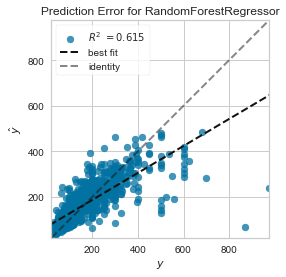

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [36]:
X_train, X_test, y_train, y_test = train_test_split(listing_data_clean.drop('price', axis = 1),
                                                    listing_data_clean['price'], test_size = 0.3, random_state = 42) 
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)
visualizer = PredictionError(rfr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

As we can see, the accuracy, or more precisely the R^2 value, is quite low. This can have various reasons, for example the large number of features. However, the plot shows us that the price predictions are not to far of. Our model tends to overestimate the prices. Nevertheless, the summary of the shap values can give us some information about the importance of the features. 

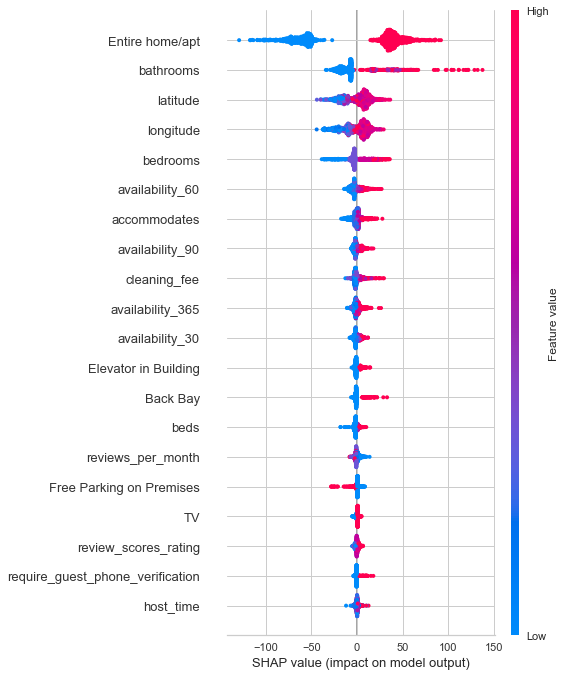

In [37]:
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X_test) 
shap.summary_plot(shap_values, X_test)

What we can see from the shap values is that the most dominant feature when it comes to predicting the price is whether the flat can be rented out completely or not. The number of bathrooms also seems to have an influence on the price. Homes with a higher number of bathrooms are more expensive. The longitude and latitude values could tell us that the price could be lower if the house is located in a region with lower longitude and latitude values, according to my barely existing geographical knowledge I would say in the southwest. One feature that stands out a little is the free parking on the property. This binary feature has a negative effect on the price prediction, i.e. if there is free parking on the property, the price is lower. A possible explanation could be that houses in the higher price range do not provide this information, perhaps for security reasons.

## Conclusion
This notebook gives a quick overview of possible questions that can be answered with the Boston Airbnb dataset. We saw that most people only spend a few days in the houses, and that some houses were rented out all year round. We have shown that the use of some descriptive adjectives seems to help attract people. And finally, we have seen that houses that can be rented out completely are more expensive. All this news may not seem surprising. Nevertheless, you should always rely on data and not just on what your gut tells you. 
 